In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pymatgen.ext.matproj import MPRester
from scipy.optimize import minimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import pandas
from ase import io
import os
from pymatgen.io.ase import AseAtomsAdaptor

import warnings
warnings.filterwarnings("error")


Need to pickle in the data we've gathered from mp


In [28]:
unary_data = pickle.load(open("../data_gather/unary_oxide_data_.p", "rb"))


Exception ignored in: <_io.FileIO name='../data_gather/unary_oxide_data_self_calc.p' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/133485820.py", line 1, in <cell line: 1>


In [15]:
def get_ref_data_oqmd(element, reference_oxide_id):
    for idx, id_ in enumerate(oqmd_info['filename']):
        if reference_oxide_id in id_:
            ref_struct = oqmd_structs[reference_oxide_id]
            ref_form_ene = oqmd_info[' _oqmd_delta_e'][idx]
            print("Reference oxide formation energy: {:.3f} eV".format(ref_form_ene))
            return ref_form_ene
        
def get_lower_hull_oqmd(low_ox_state_data, oxidation_state, ref_form_ene, reference_element_, oxidising=True):
    """
    Returns the lower hull through the desired points along the phase diagram.
    low_ox_state_data: Dictionary returned from the result of get_ox2lowest
    oxidation_state: The reference oxidation state from which we oxidise/reduce
    oxidising: Set to True if we want the hull oxidised, False if we want it reduced
    """
    pairs = [[0,0]]
    if oxidising:
        for ox in low_ox_state_data:
             if ox<=8 and oxidation_state==4:
                pairs.append((ox-oxidation_state,low_ox_state_data[ox]-ref_form_ene ))

        if len(pairs)==2:
            # need to add oxygen end member data
            pairs.append((oxidation_state, -ref_form_ene))
        pairs = np.array(pairs)
        try:
            hull = ConvexHull(pairs)
        except Exception as e:
            print(e)
            print("{} needs to be done differently.".format(reference_element_))
            return None
    else:
        for ox in low_ox_state_data:
            pairs.append((oxidation_state-ox,low_ox_state_data[ox]-ref_form_ene ))
        if (reference_element_=='Ni' or reference_element_=='Co'):
            # we know the minimum is 2, and we need the line to curve through there
            diff = oxidation_state-2
            pairs.append((diff*2, 0))
        pairs = np.array(pairs)

        try:
            hull = ConvexHull(pairs)
        except Exception as e:
            print(e)
            print(" needs to be done differently.".format(reference_element_))
            return None
    resultant_hull = get_lower_hull_points(hull, pairs)
    return resultant_hull


def get_ox2lowest_oqmd(reference_element_, ref_id, oxidising=True):
    """
    Returns a dictionary for a given element with keys for oxidation states and 
    values for the lowest formation energy at that oxidation state
    """
    ref_form_ene = get_ref_data_oqmd(reference_element_, ref_id)
    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)

    for idx, oqmd_id in enumerate(oqmd_ids):
        m_coordinations, ox_state, o_o_coords, _, _ = structure_inspection(oqmd_structs[oqmd_id])
        if reference_element_ in ['Pd', 'Pt', 'Ir', 'Rh'] and ox_state>4 and list(set(o_o_coords))==[0] and list(set(m_coordinations))==[6]:
            print(m_coordinations, ox_state, o_o_coords, oqmd_enes[oqmd_id], oqmd_id)

        if oxidising:
            bool2check = ox_state>4
        else:
            bool2check = ox_state<4
        
        if (bool2check):
            formation_energy = oqmd_enes[oqmd_id]
            ox2data[ox_state].append(formation_energy)
            if ox_state not in ox2lowest.keys():
                ox2lowest[ox_state] = formation_energy

            elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state]:
                ox2lowest[ox_state] = formation_energy
    return ox2lowest


def get_entry_by_spacegroup(oqmd_properties, spacegroup):
    """
    Returns the relevant ID which finds the matching oxide for a given stoichiometry,
    eg. P42/mnm for rutile
    """
    matching_rows = set()
    for row in oqmd_properties.values:
        if spacegroup in row:
            matching_rows.add(row[0])
    return matching_rows

In [35]:
def get_ref_data(element, reference_oxide_id, desired_ox=None):
    found = False
    
    if reference_oxide_id is None:
        # need to retrieve made up formation energy
        print("Making synthetic formation energy, since MP doesn't have data for {} in ox state: {}".format(element, desired_ox))
        ene_dict, val = get_ox2lowest_no_reference_(element, desired_ox)
        return val, _, _

    for idx, id_ in enumerate(unary_data[element]['mp_ids']):
        if id_==reference_oxide_id:
            found = True
            ref_struct = unary_data[element]['structures'][idx]
            ref_form_ene = unary_data[element]['formation_energies'][idx]
            return ref_form_ene, ref_struct
    
    print("You probably mis-named ones of the reference oxides.")
    return 

def get_ox2lowest_no_reference_(reference_element_, ref_oxidation_state):
    """
    Returns a dictionary for a given element with keys for ox state and 
    values for the lowest formation energy at ox state.
    Args:
    reference_element_: The element to iterate over, passed as a string
    """
    ox2lowest = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):

        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        formation_energy = unary_data[reference_element_]['formation_energies'][idx]
        
        if ox_state not in ox2lowest.keys():
            ox2lowest[ox_state] = formation_energy
        elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state]:
            ox2lowest[ox_state] = formation_energy
    #print(ox2lowest)
    print(ox2lowest)
    if ref_oxidation_state not in ox2lowest.keys():
        synthetic_ref_form = add_ox(ox2lowest, ref_oxidation_state)
        ox2lowest[ref_oxidation_state] = synthetic_ref_form
        
    return ox2lowest, ox2lowest[ref_oxidation_state]
        
def uncorr_ene_from_formation_energy(formation_energy_correction, ele1, ele2, ele1_conc, o_conc):
    """
    Return the synthetically calculated uncorrected DFT energy given a formation energy correction with
    respect to the reference oxides.
    Args:
    formation_energy_correction: The value below the weighted average of ele1/ele2 oxides, float.
    ele1: One of the mixed elements passed as a string.
    ele2: The other element, passed as a string.
    ele1_conc: The concentration of ele1, float between 0 and 1. eg. one-to-one mixture would have ele1_conc=0.5.
    o_conc: The oxygen concentration, float between 0 and 1. Eg. for MO2, o_conc=2/3.
    """
    o_energy = -4.948
    o_correction = -0.687
    ele1_ene, ele1_fingerprint, ele1_struct = get_ref_data(ele1, ele2mp[ele1])
    ele2_ene, ele2_fingerprint, ele2_struct = get_ref_data(ele2, ele2mp[ele2])
    #print(ele1_ene)
    corr_ele1_ene = mpr.get_entries(ele2mp[ele1])[0].energy_per_atom
    corr_ele2_ene = mpr.get_entries(ele2mp[ele2])[0].energy_per_atom
    ele1_ene = corr_ele1_ene-o_conc*o_energy-(1-o_conc)*ele2gs[ele1]
    ele2_ene = corr_ele2_ene-o_conc*o_energy-(1-o_conc)*ele2gs[ele2]

    total_form_ene = ele1_ene*ele1_conc+ele2_ene*(1-ele1_conc)+formation_energy_correction
    end_member_ene = (1-o_conc)*(ele1_conc*ele2gs[ele1]+(1-ele1_conc)*ele2gs[ele2])+(o_conc)*(o_energy)
    corrections = o_conc*(o_correction)
    # now get the corrections that would be applied per atom
    if ele1 in u_correction.keys():
        corrections += (1-o_conc)*(ele1_conc*u_correction[ele1])
    if ele2 in u_correction.keys():
        corrections += (1-o_conc)*((1-ele1_conc)*u_correction[ele2])
    # by definition formation energy = (mixed system energy) - (end member energy), here we just manipulate
    # that equation and remove the MP corrections.
    uncorr_energy = total_form_ene+end_member_ene

    return uncorr_energy 


def make_synthetic_mp(energy_correction, ele1, ele2, ele1_conc, o_conc):
    """
    Make a PourbaixDiagram, PDEntry object to be passed to the plotter
    Args:
    energy_correction: Difference in weighted formation energy, float
    ele1, ele2: The chemical symbol of the non-oxygen elements in the oxide, str
    ele1_conc: The concentration of ele1, varies from 0 to 1.
    o_conc: The amount of oxygen in the made up entry, eg. for MO2, would be 2/3
    """
    name = "{}{}{}{}O{}".format(ele1, (1-o_conc)*(ele1_conc), ele2, (1-o_conc)*(1-ele1_conc), o_conc)
    composition = Composition(name)
    label = "{}{:.2f}{}{:.2f}O{:.2f}".format(ele1, (3)*(1-o_conc)*(ele1_conc), ele2, (3)*(1-o_conc)*(1-ele1_conc), (3)*o_conc)
    energy = uncorr_ene_from_formation_energy(energy_correction, ele1, ele2, ele1_conc, o_conc)
    entry = PDEntry(composition, energy, name=label)
    return entry, label


def get_hull_energy(min_mu_o, max_mu_o, entries):
    list_mu_Os = np.linspace(min_mu_o, max_mu_o, 10)
    data = []
    hull = []
    for mu_Os in list_mu_Os:
        open_elements_specific = {Element("O"):mu_Os}
        gcpd = GrandPotentialPhaseDiagram(entries, open_elements_specific)
        l = [gcpd.get_form_energy_per_atom(e) for e in gcpd.all_entries]
        h = [gcpd.get_e_above_hull(e) for e in gcpd.all_entries]
        data.append(l)
        hull.append(h)
    hull = np.array(hull)
    data = np.array(data)
    return hull, data, gcpd, list_mu_Os

def load_data(ele1, ele2):
    entries = []
    labels = []
    entries_1 = mpr.get_entries('{}-{}-O'.format(ele1, ele2))+mpr.get_entries('{}-O'.format(ele1))+mpr.get_entries('{}-O'.format(ele2))
    for entry in entries_1:
        if 'H' in entry.name:
            continue
        entries.append(entry)
        labels.append(entry.name)
    return entries, labels


def structure_inspection(structure):
    """
    Need to know the coordination and other structural data for a given oxide
    """
    num_o_sites = 0 
    m_coordinations = []
    o_o_coordinations = []
    o_m_coordinations = []
    for site in structure.sites:
        if str(site.specie)=='O':
            num_o_sites += 1
            nn_info = structure.get_neighbors(site, 2.5)
            o_coord = 0
            o_m_coord = 0
            for nn in nn_info:
                #print(str(nn.specie))
                if str(nn.specie)=="O" and nn.nn_distance<1.5:
                    o_coord+=1
                elif str(nn.specie)!="O":
                    o_m_coord+=1
                #assert str(nn.specie)=='O'
            o_o_coordinations.append(o_coord)
            o_m_coordinations.append(o_m_coord)
        else:
            # check nearest neighbours for coordination
            nn_info = structure.get_neighbors(site, 2.5)
            m_coord = 0
            for nn in nn_info:
                #print(str(nn.specie))
                if str(nn.specie)=="O":
                    m_coord+=1
                #assert str(nn.specie)=='O'
            m_coordinations.append(m_coord)
    o_percent = num_o_sites/len(structure.sites)
    ox_state = round((o_percent*2/(1-o_percent)), 3)
    return m_coordinations, ox_state, o_o_coordinations, o_m_coordinations, round(o_percent, 3)

def add_ox(energy_dict, desired_ox_state):
    """
    Makes a synthetic entry in the dictionary for a given oxidation state if it doesn't exist
    """
    ox_states = list(energy_dict.keys())
    ox_states_ = ox_states.copy()
    assert desired_ox_state not in ox_states
    
    ox_states_.append(desired_ox_state)
    # we need two points to project between or from to the desired oxidation state
    # if the desired points has examples either side of it, we handle that here
    minused = np.array(ox_states)-desired_ox_state
    if min(minused)<0 and max(minused)>0:
        # there are points with higher/lower ox states than the desired ox
        # initialise dummy check values
        closest_higher_ox = 10
        closest_lower_ox = -10
        for val in minused:
            if val<0 and val>closest_lower_ox:
                closest_lower_ox = val
            elif val>0 and val<closest_higher_ox:
                closest_higher_ox = val
        closest_lower_ox+=desired_ox_state
        closest_higher_ox+=desired_ox_state
        # need to ensure the key is right
        form_ene1 = energy_dict[round(closest_lower_ox, 3)]
        form_ene2 = energy_dict[round(closest_higher_ox, 3)]
        # get weighted average
        adapted = form_ene1*(abs(closest_higher_ox)/(abs(closest_lower_ox)+abs(closest_higher_ox)))+form_ene2*(abs(closest_lower_ox)/(abs(closest_lower_ox)+abs(closest_higher_ox)))
        return adapted
    
    elif min(minused)<0:
        # trying to get a value for a point which has no info at higher oxidation states        
        sorted_index_array = np.argsort(np.array(ox_states))
        sorted_array = np.array(ox_states)[sorted_index_array]
        # take 2 largest values
        rslt = sorted_array[-2:]
        lower_ox = min(rslt[0], rslt[1])
        higher_ox = max(rslt[0], rslt[1])
        l_ox_ene = energy_dict[lower_ox]
        h_ox_ene = energy_dict[higher_ox]
        # use eq. of line
        m = (h_ox_ene-l_ox_ene)/(higher_ox-lower_ox)
        c = h_ox_ene-m*higher_ox
        y_new = m*desired_ox_state+c
        return y_new
        
        
def plot_coords(reference_element_):
    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        mpid = unary_data[reference_element_]['mp_ids'][idx]
        mp_ids.append(mpid)
        query = mpr.get_entry_by_material_id(mpid, property_data=['formation_energy_per_atom',])
        formation_energy = query.data['formation_energy_per_atom']
        if set(list(m_coordinations))=={6}:
            plt.plot(ox_state, formation_energy, 'bo', alpha=0.1)
        elif set(list(m_coordinations))=={4}:
            plt.plot(ox_state, formation_energy, 'ro', alpha=0.9)
            #print(mpid)
        elif set(sorted(list(m_coordinations)))=={5}:
            plt.plot(ox_state, formation_energy, 'go', alpha=0.9)
        #else:
        #    plt.plot(ox_state, formation_energy, 'yo', alpha=0.7)

    plt.show()
def get_conc_in_binary(structure, element):
    element_count = 0
    other_element_count = 0
    for site in structure.sites:
        if str(site.specie)==element:
            element_count+=1
        elif str(site.specie)=='O':
            continue
        else:
            other_element_count+=1
    return element_count/(element_count+other_element_count)



def get_quadratic(lower_hull_data, max_x=4):
    """
    Iterate over the hull dictionary to get x and y to fit 2nd order polynomial through those points
    """
    xs = []
    ys = []
    for ox in lower_hull_data:
        xs.append(ox)
        ys.append(lower_hull_data[ox])

    coeffs_ = np.polyfit(xs, ys, 2)
    x = np.linspace(0, max_x, 100)
    y = coeffs_[0]*x**2 + coeffs_[1]*x + coeffs_[2]
    plt.plot(x, y)
    plt.show()
    
    return coeffs_


def check_if_upper(upper_hull_points, hull_simplex):
    """
    Helper function so that for loop in get_lower_hull_points function can be skipped when
    we see a point that is on the upper half of the hull.
    """
    for index in upper_hull_points:
        if index in hull_simplex:
            return True
    return False
    
def get_lower_hull_points(hull_, pairs_, plotting=True):
    """
    Function to remove points on the upper half of the hull, these are unstable and ignored,  
    to handle the fact that scipy gets the entire hull not just the low energy points we want.
    Args: 
    hull_: Returned value from scipy's ConvexHull, where the x-axis is oxidation state and the
    y-axis is formation energy.
    pairs_: The values themselves, pairs_[i, 0] gives the ith oxidation state
    pairs_[i, 1] the ith formation energy.
    plotting: Whether to plot the points to be fitted through
    """
    points_on_upper_hull = set()
    for vertex_index, vertex in enumerate(hull_.vertices):
        # check if on upper or lower half of hull
        for simplex in hull_.simplices:
            low_ox = min(pairs_[simplex, 0])
            low_ox_ene = pairs_[simplex, 1][np.argmin(pairs_[simplex, 0])]
            high_ox = max(pairs_[simplex, 0])
            high_ox_ene = pairs_[simplex, 1][np.argmax(pairs_[simplex, 0])]
            difference = high_ox - low_ox
            vertex_ox = pairs_[vertex, 0]
            vertex_diff = vertex_ox-low_ox

            difference_ratio = vertex_diff/difference
            value_on_hull = high_ox_ene*(1-difference_ratio)+low_ox_ene*(difference_ratio)
            if low_ox<pairs_[vertex,0]<high_ox and value_on_hull<pairs_[vertex,1]:
                # if this is true it means the oxidation state is between two other oxidation states on the hull,
                # and lies above the weighted average on the line connecting those oxidation states
                points_on_upper_hull.add(hull_.vertices[vertex_index])
        
    hullox2ene = defaultdict()
    for simplex in hull_.simplices:
        if check_if_upper(points_on_upper_hull, simplex):
            continue
        hullox2ene[pairs_[simplex, 0][0]] = pairs_[simplex, 1][0]
        hullox2ene[pairs_[simplex, 0][1]] = pairs_[simplex, 1][1] 
        if plotting:
            
            plt.plot(pairs_[simplex, 0], pairs_[simplex, 1], 'k--')
            plt.plot(pairs_[simplex, 0][0], pairs_[simplex, 1][0], 'ro')
            plt.plot(pairs_[simplex, 0][1], pairs_[simplex, 1][1], 'ro')

    return hullox2ene

def get_lower_hull(low_ox_state_data, ref_oxidation_state, ref_formation_ene, reference_element_, oxidising=True):
    """
    Returns the lower hull through the desired points along the phase diagram.
    low_ox_state_data: Dictionary returned from the result of get_ox2lowest
    ref_formation_ene: Formation energy in eV/atom of refernece state.
    ref_oxidation_state: The reference oxidation state from which we oxidise/reduce
    oxidising: Set to True if we want the hull oxidised, False if we want it reduced
    """
    pairs = [[0,0]]
    if oxidising:
        for ox in low_ox_state_data:
            #print(ox)
            if ox>6 and reference_element_ not in ['Ru', 'Mo', 'W', 'Re', 'Sb']:
                plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            #if reference_element_ in ['Sb',] and ox==6:# or (reference_element_=='Mo' and ox==5):
            #    plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                # need Sb minima at Sb2O5
            #    continue
            if reference_element_=='W' and not ox.is_integer():
                # need to fit through WO3,this allows that
                plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                print(ox)
                #pairs.append((ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene ))
                continue
            if reference_element_=='Te' and ox==4.5:
                plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            else:
                pairs.append((ox-ref_oxidation_state,low_ox_state_data[ox][0]-ref_formation_ene ))
    else:
        for ox in low_ox_state_data:
            print(ox)
            if reference_element_=='Ni' and 2.5<ox<3 and ref_oxidation_state==4:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if (reference_element_=='Cu' and (ox!=2)) and ref_oxidation_state==4:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            elif reference_element_=='Fe' and not ox.is_integer() and ref_oxidation_state==4:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
#             elif (reference_element_=='Cr' and ox==2 or ox==2.4)and ref_oxidation_state==4:
#                 plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
#                 continue
            if reference_element_ in ['Ni', 'Ca', 'Mg', 'Pt', 'Pd', 'Cu', 'Ba', 'Cs', 'Rb', 'Yb', 'Zn'] and ref_oxidation_state==4:
                # push to have minimum close to MO
                pairs.append((4, 0.))
            if reference_element_ in ['Dy', 'Tb', 'Tm'] and ref_oxidation_state==4:
                # push to have minimum close to M2O3
                pairs.append((2, 0.))
            if reference_element_=='Na' and ox!=1:
                continue
            if reference_element_ in ['Li','Na'] and ref_oxidation_state==4:
                # push to have minimum close to M2O
                pairs.append((6, 0.))
            if reference_element_ in ['Sm',] and ref_oxidation_state==4 and ox==1:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='Pb' and ref_oxidation_state==4 and ox>2:
                # forces to fit through PbO
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='Rb' and ref_oxidation_state==4 and ox==1:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            pairs.append((ref_oxidation_state-ox,low_ox_state_data[ox][0]-ref_formation_ene ))        
            
    if len(pairs)==2 or (reference_element_=='W' and oxidising):
        # need to add oxygen end member data
        print("WARNING! Adding an end member so can perform fit, try gather more data for this element.")
        pairs.append((ref_oxidation_state, -ref_formation_ene))
        if not (reference_element_=='W' and oxidising):
            return None
    
    pairs = np.array(pairs)

    try:
        hull = ConvexHull(pairs)
    except Exception as e:
        print(e)
        print("{}  needs to be done differently.".format(reference_element_))
        if oxidising:
            plt.title("{} oxidising, not enough data".format(reference_element_))
        else:
            plt.title("{} reducing, not enough data".format(reference_element_))
        plt.show()
        return None
    
    if oxidising:
        plt.title("{} oxidising".format(reference_element_))
    else:
        plt.title("{} reducing".format(reference_element_))
    resultant_hull = get_lower_hull_points(hull, pairs)
    return resultant_hull



def get_ox2lowest(reference_element_, reference_mpid, ref_oxidation_state, oxidising=True):
    """
    Returns a dictionary for a given element with keys for oxidation states and 
    values for the lowest formation energy at that oxidation state
    Args:
    reference_element_: The element to iterate over, passed as a string
    reference_mpid: The mp-id being taken as a reference, passed as string
    ref_oxidation_state: The reference oxidation state, passed as an int.
    oxidising: Whether we want the dictionary of the oxidation state to formation energies with 
    oxidation states higher (oxidising=True) or lower (oxidising=False) than ref_oxidation_state
    """
    ref_form_ene, ref_structure_ = get_ref_data(reference_element_, reference_mpid)
    ref_m_coords, ref_ox_state, ref_o_o_coords, ref_o_m_coords, ref_o_pc = structure_inspection(ref_structure_)
    assert ref_ox_state==ref_oxidation_state
    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)

        mpid = unary_data[reference_element_]['mp_ids'][idx]
        mp_ids.append(mpid)
        if oxidising:
            bool2check = ox_state>ref_oxidation_state# and sum(o_o_coords)==0# and max(o_o_coords)==0
        else:
            bool2check = ox_state<ref_oxidation_state# and sum(o_o_coords)==0# and max(o_o_coords)==0
        # this determines whether to save the entry based on coordinations, if your reference is different
        if bool2check:

            formation_energy = unary_data[reference_element_]['formation_energies'][idx]
            ox2data[ox_state].append(formation_energy)

            if ox_state not in ox2lowest.keys():# and e_above_hull<1:
                ox2lowest[ox_state] = (formation_energy, _)
            elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state][0]:
                ox2lowest[ox_state] = (formation_energy, _)
    return ox2lowest, ref_form_ene


def get_ox2lowest_no_reference(reference_element_):
    """
    Returns a dictionary for a given element with keys for oxygen concentration and 
    values for the lowest formation energy at that concentration from 0 to 1.
    Args:
    reference_element_: The element to iterate over, passed as a string
    """
    conc2lowest = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):

        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        
        #query = unary_data[reference_element_]['fingerprints'][idx]#mpr.get_entry_by_material_id(mpid, property_data=['formation_energy_per_atom', 'e_above_hull'])
        formation_energy = unary_data[reference_element_]['formation_energies'][idx]

        if o_pc not in conc2lowest.keys():
            conc2lowest[o_pc] = formation_energy
        elif o_pc in conc2lowest.keys() and formation_energy<conc2lowest[o_pc]:
            conc2lowest[o_pc] = formation_energy
    return conc2lowest




Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


Ge
Reference oxide formation energy: -1.889 eV
Reference oxide formation energy: -1.889 eV
not much info ...


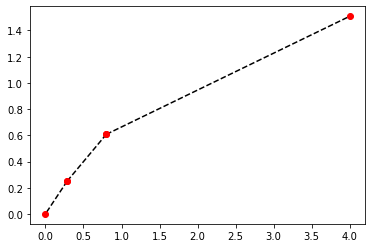

Reference oxide formation energy: -1.889 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Se
Reference oxide formation energy: -0.593 eV
Reference oxide formation energy: -0.593 eV
not much info ...


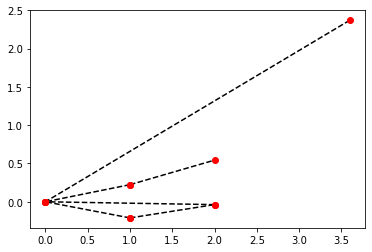

Reference oxide formation energy: -0.593 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


returning linear eq
Ti
Reference oxide formation energy: -3.216 eV
Reference oxide formation energy: -3.216 eV
not much info ...


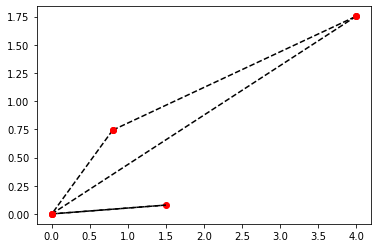

Reference oxide formation energy: -3.216 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
V
Reference oxide formation energy: -2.501 eV
Reference oxide formation energy: -2.501 eV
not much info ...


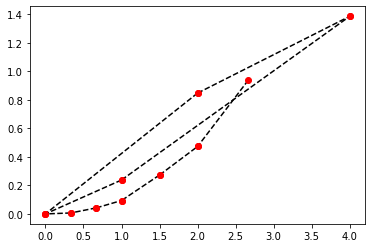

Reference oxide formation energy: -2.501 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Cr
Reference oxide formation energy: -2.114 eV
Reference oxide formation energy: -2.114 eV
not much info ...


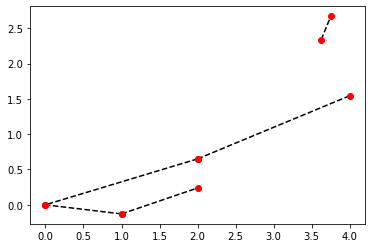

Reference oxide formation energy: -2.114 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Mn
Reference oxide formation energy: -1.712 eV
Reference oxide formation energy: -1.712 eV
not much info ...


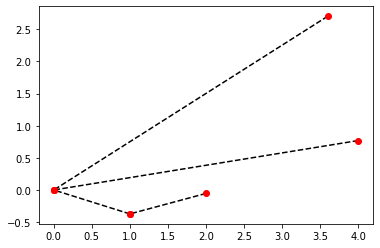

Reference oxide formation energy: -1.712 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Fe
Reference oxide formation energy: -1.304 eV
Reference oxide formation energy: -1.304 eV
not much info ...


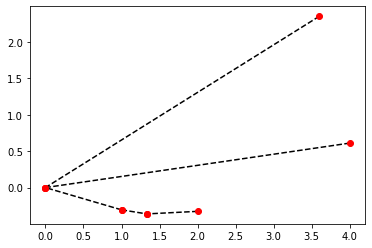

Reference oxide formation energy: -1.304 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Co
Reference oxide formation energy: -0.991 eV
Reference oxide formation energy: -0.991 eV
not much info ...


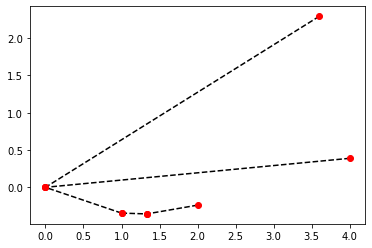

Reference oxide formation energy: -0.991 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Ni
Reference oxide formation energy: -0.482 eV
Reference oxide formation energy: -0.482 eV
not much info ...


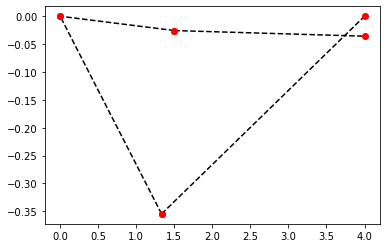

Reference oxide formation energy: -0.482 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Nb
Reference oxide formation energy: -2.692 eV
Reference oxide formation energy: -2.692 eV
not much info ...


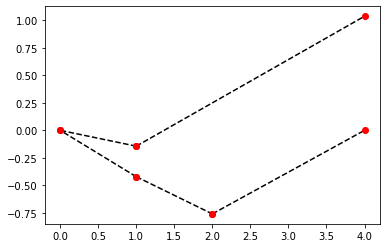

Reference oxide formation energy: -2.692 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Mo
Reference oxide formation energy: -2.099 eV
Reference oxide formation energy: -2.099 eV
not much info ...


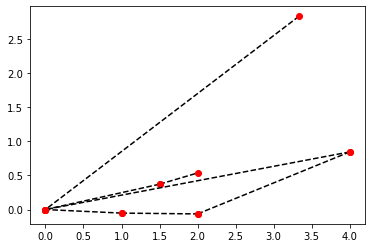

Reference oxide formation energy: -2.099 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Tc
Reference oxide formation energy: -1.651 eV
Reference oxide formation energy: -1.651 eV
not much info ...


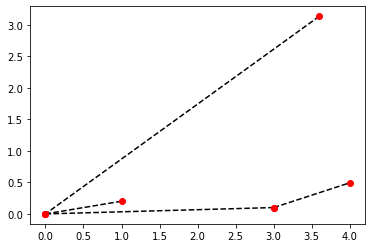

Reference oxide formation energy: -1.651 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Ru
Reference oxide formation energy: -1.268 eV
Reference oxide formation energy: -1.268 eV
not much info ...


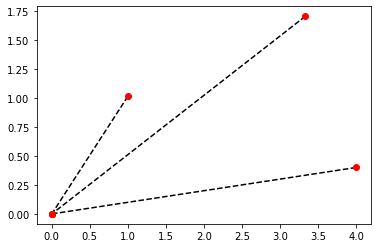

Reference oxide formation energy: -1.268 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Rh
Reference oxide formation energy: -1.040 eV
Reference oxide formation energy: -1.040 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.3062 ID-318726
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.5166 ID-690792
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4091 ID-694990
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4832 ID-694989
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.511 ID-825006
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4282 ID-825032
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4343 ID-825033
[6] 8.0 [0, 0, 0, 0] -0.2241 ID-1338398
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] -0.085 ID-1343165
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.3062 ID-318726
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.5166 ID-690792
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4091 ID-694990
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4832 ID-694989
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.511 ID-825006
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4282 ID-825032
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -

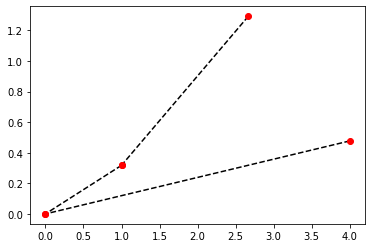

Reference oxide formation energy: -1.040 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.3062 ID-318726
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.5166 ID-690792
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4091 ID-694990
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4832 ID-694989
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.511 ID-825006
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4282 ID-825032
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4343 ID-825033
[6] 8.0 [0, 0, 0, 0] -0.2241 ID-1338398
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] -0.085 ID-1343165
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.3062 ID-318726
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.5166 ID-690792
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4091 ID-694990
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4832 ID-694989
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.511 ID-825006
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4282 ID-825032
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4343 ID-825033
[6] 8.0 [0, 0, 0, 0] -0.2241 ID-1338398
[6, 6] 8.0

Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.3062 ID-318726
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.5166 ID-690792
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4091 ID-694990
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4832 ID-694989
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.511 ID-825006
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4282 ID-825032
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4343 ID-825033
[6] 8.0 [0, 0, 0, 0] -0.2241 ID-1338398
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] -0.085 ID-1343165
not enough info ...
Pd
Reference oxide formation energy: -0.542 eV
Reference oxide formation energy: -0.542 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
not much info ...


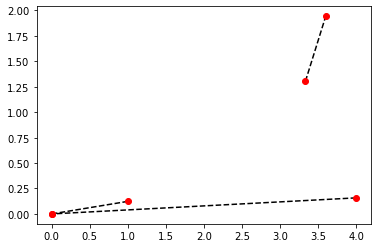

Reference oxide formation energy: -0.542 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
not enough info ...
Sn
Reference oxide formation energy: -1.954 eV
Reference oxide formation energy: -1.954 eV
returning linear eq


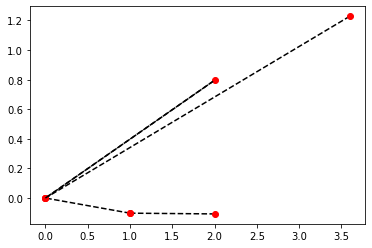

Reference oxide formation energy: -1.954 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Sb
Reference oxide formation energy: -1.484 eV
Reference oxide formation energy: -1.484 eV
not much info ...


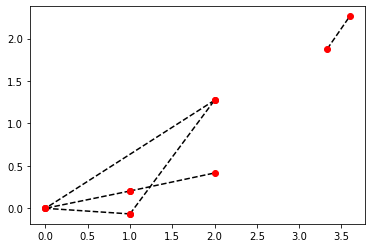

Reference oxide formation energy: -1.484 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Te
Reference oxide formation energy: -1.089 eV
Reference oxide formation energy: -1.089 eV
not much info ...


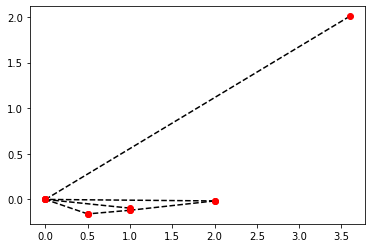

Reference oxide formation energy: -1.089 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Ta
Reference oxide formation energy: -2.853 eV
Reference oxide formation energy: -2.853 eV
not much info ...


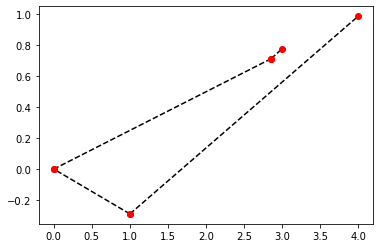

Reference oxide formation energy: -2.853 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
W
Reference oxide formation energy: -2.119 eV
Reference oxide formation energy: -2.119 eV
not much info ...


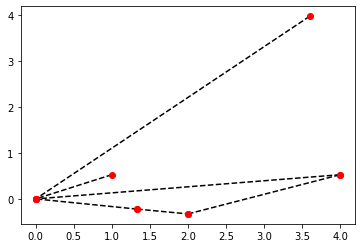

Reference oxide formation energy: -2.119 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Re
Reference oxide formation energy: -1.588 eV
Reference oxide formation energy: -1.588 eV
not much info ...


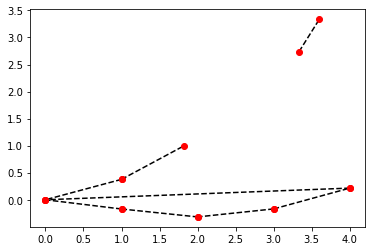

Reference oxide formation energy: -1.588 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Os
Reference oxide formation energy: -1.161 eV
Reference oxide formation energy: -1.161 eV
not much info ...


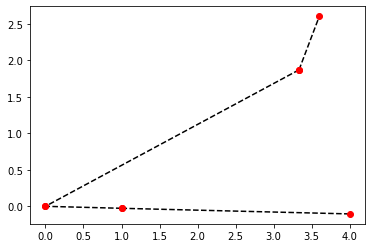

Reference oxide formation energy: -1.161 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Ir
Reference oxide formation energy: -1.064 eV
Reference oxide formation energy: -1.064 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.1735 ID-325288
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.7798 ID-690788
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.7156 ID-694982
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.7947 ID-694981
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.7769 ID-825007
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.6605 ID-825035
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.6593 ID-825034
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.8429 ID-1376066
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.8407 ID-1708421
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.6528 ID-1710517
[6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0] -0.7565 ID-1710518
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.6515 ID-1758933
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.7215 ID-1758934
[6] 8.0 [0, 0, 0, 0] -0.3511 ID-1270036
[6] 8.0 [0, 0, 0, 0] -0.3515 ID-1338389
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] -0.5091 ID-1

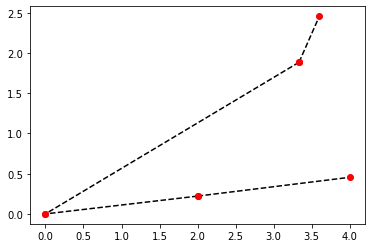

Reference oxide formation energy: -1.064 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.1735 ID-325288
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.7798 ID-690788
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.7156 ID-694982
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.7947 ID-694981
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.7769 ID-825007
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.6605 ID-825035
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.6593 ID-825034
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.8429 ID-1376066
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.8407 ID-1708421
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.6528 ID-1710517
[6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0] -0.7565 ID-1710518
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.6515 ID-1758933
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.7215 ID-1758934
[6] 8.0 [0, 0, 0, 0] -0.3511 ID-1270036
[6] 8.0 [0, 0, 0, 0] -0.3515 ID-1338389
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] -0.5091 ID-1343155
[6, 6] 5.0 [0, 0, 0, 0, 0] -0.7744 ID-1443330
[6, 6] 6.0 [0,

Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


Reference oxide formation energy: -0.700 eV
Reference oxide formation energy: -0.700 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.4074 ID-318480
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.3287 ID-690791
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2299 ID-694988
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2536 ID-694987
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.3231 ID-824999
[6] 8.0 [0, 0, 0, 0] -0.1037 ID-1338396
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] 0.0976 ID-1343163
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.4074 ID-318480
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.3287 ID-690791
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2299 ID-694988
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2536 ID-694987
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.3231 ID-824999
[6] 8.0 [0, 0, 0, 0] -0.1037 ID-1338396
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] 0.0976 ID-1343163
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.4074 ID-318480
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.3287 ID-690791
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2299 ID-694988
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2536 ID-694987
[6, 6, 

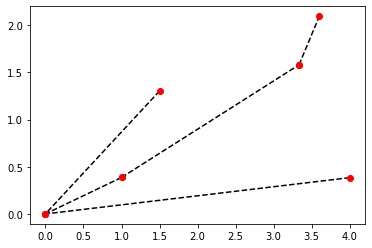

Reference oxide formation energy: -0.700 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.4074 ID-318480
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.3287 ID-690791
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2299 ID-694988
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2536 ID-694987
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.3231 ID-824999
[6] 8.0 [0, 0, 0, 0] -0.1037 ID-1338396
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] 0.0976 ID-1343163
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.4074 ID-318480
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.3287 ID-690791
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2299 ID-694988
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2536 ID-694987
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.3231 ID-824999
[6] 8.0 [0, 0, 0, 0] -0.1037 ID-1338396
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] 0.0976 ID-1343163
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.4074 ID-318480
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.3287 ID-690791
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2299 ID-694988
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2536 ID-694987
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.4074 ID-318480
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.3287 ID-690791
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2299 ID-694988
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2536 ID-694987
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.3231 ID-824999
[6] 8.0 [0, 0, 0, 0] -0.1037 ID-1338396
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] 0.0976 ID-1343163
not enough info ...
Tl
Reference oxide formation energy: -0.392 eV
Reference oxide formation energy: -0.392 eV
not much info ...


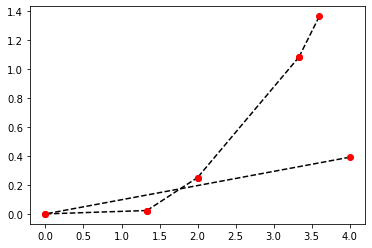

Reference oxide formation energy: -0.392 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Ti
Reference oxide formation energy: -3.216 eV
Reference oxide formation energy: -3.216 eV
not much info ...


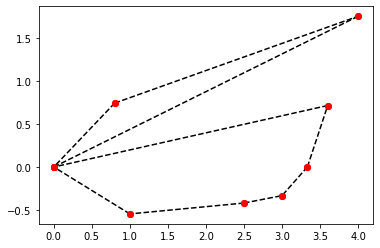

Reference oxide formation energy: -3.216 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Nb
Reference oxide formation energy: -2.692 eV
Reference oxide formation energy: -2.692 eV
not much info ...


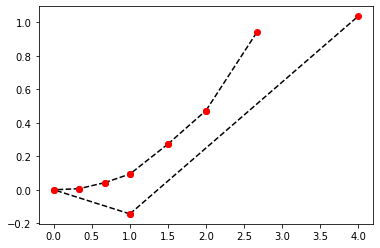

Reference oxide formation energy: -2.692 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Pb
Reference oxide formation energy: -1.115 eV
Reference oxide formation energy: -1.115 eV
returning linear eq


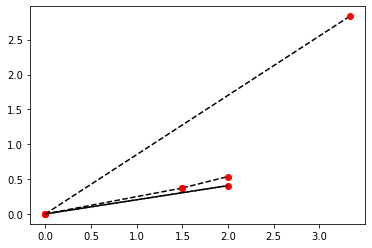

Reference oxide formation energy: -1.115 eV


Exception ignored in: <function Popen.__del__ at 0x7fe5e820b310>
Traceback (most recent call last):
  File "/Users/michael/anaconda3/envs/acid_stable_pbx/lib/python3.8/subprocess.py", line 946, in __del__
    _warn("subprocess %s is still running" % self.pid,
Exception ignored in: <_io.FileIO name=76 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/1035330042.py", line 37, in <cell line: 16>


not enough info ...
Bi
Reference oxide formation energy: -1.285 eV
Reference oxide formation energy: -1.285 eV
not much info ...


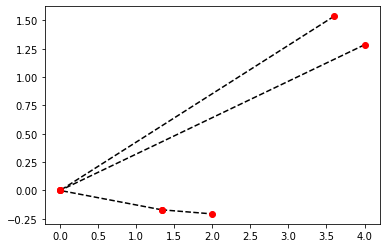

Reference oxide formation energy: -1.285 eV
not enough info ...


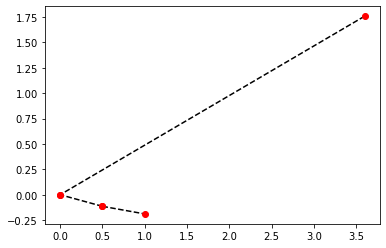

In [19]:
# specific to these elements being searched for in oqmd
elements2consider = [ 'Ge', 'Se',
    'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 
     'Nb', 'Mo', 'Tc',
    
    'Ru', 'Rh', 'Pd', 'Sn', 'Sb', 'Te',
    'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Tl', 'Ti', 'Nb', 'Pb',
    'Bi',
]

directory_path = "../data_gather/oqmd_data"
ref_oxidation_state = 4
quadratic_equations_ox = defaultdict()
quadratic_equations_red = defaultdict()

for ele in elements2consider:
    oqmd_info = pandas.read_csv("{}/target_props/target_properties_{}o2.csv".format(directory_path, ele))
    print(ele)
    oqmd_enes = defaultdict()
    #print(oqmd_info)
    spg_match_data = get_entry_by_spacegroup(oqmd_info, "P42/mnm")
    if ele=='Bi':
        spg_match_data = get_entry_by_spacegroup(oqmd_info, "C2/c")
    matching_ids = []
    for match in spg_match_data:
        matching_ids.append(match.split("En")[1].split(".")[0])
    #print(spg_match_data)
    #continue
    oqmd_ids = []
    for name, energy in zip(oqmd_info['filename'], oqmd_info[' _oqmd_delta_e']):
        #print(energy, name)
        oqmd_id = name.split("En")[1].split('.')[0]
        oqmd_enes[oqmd_id] = energy
        #oqmd_enes[poscar.split("_")[0]] = oqmd_info[' _oqmd_delta_e'][idx]
        oqmd_ids.append(oqmd_id)

    poscars = os.popen("ls {}/input_poscars/input_poscars_{}o2".format(directory_path, ele)).readlines()
    poscars = [x.strip("\n") for x in poscars]
    oqmd_structs = defaultdict()
    for poscar in poscars:
        struct = io.read("{}/input_poscars/input_poscars_{}o2/{}".format(directory_path, ele, poscar))
        pymat_struct = AseAtomsAdaptor.get_structure(struct)
        oqmd_structs[poscar.split("En")[1].split('.')[0]] = pymat_struct
        
    # need to find the reference id
    reference_found = False
    for match in matching_ids:
        cords, oxi_state, o_o_coords, _, _ = structure_inspection(oqmd_structs[match])
        #print(data)
        if oxi_state==ref_oxidation_state:
            reference_id = match
            reference_found = True
            
    assert reference_found
    #continue
    
    #for ele in ['Sn']:
    #print(ele)
    ref_ene = get_ref_data_oqmd(ele, reference_id)

    ox2low = get_ox2lowest_oqmd(ele, reference_id, oxidising=True)
    hull_ox2energy = get_lower_hull_oqmd(ox2low, 4,ref_ene, ele, oxidising=True)
    
        
    #print(list(hull_ox2energy.keys())
    if hull_ox2energy is not None:
        other_oxes = list(hull_ox2energy.keys())

    if len(other_oxes)==2 and 4.0 not in other_oxes and hull_ox2energy is not None:
        # add end member to allow for a fitted quadratic equation
        non_ref = sorted(other_oxes)[1]
        coeffs = [0, hull_ox2energy[non_ref]/non_ref, 0]
        print('returning linear eq')
        plt.plot([0, non_ref], [0, hull_ox2energy[non_ref]], 'k--')
        quadratic_equations_ox[ele] = coeffs
    else:
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        print("not much info ...")
        quadratic_equations_ox[ele] = [0, -ref_ene/4,0]
    plt.show()
    
    ox2low = get_ox2lowest_oqmd(ele, reference_id, oxidising=False)
    hull_ox2energy = get_lower_hull_oqmd(ox2low, 4,ref_ene, ele, oxidising=False)
    
    if hull_ox2energy is None:
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        quadratic_equations_red[ele] = [0, -ref_ene/4,0]
        
    if hull_ox2energy is not None:
        other_oxes = list(hull_ox2energy.keys())

    if len(other_oxes)==2 and 4.0 not in other_oxes and hull_ox2energy is not None:
        # just return the linear equation which passes through the observed point
        non_ref = sorted(other_oxes)[1]
        coeffs = [0, hull_ox2energy[non_ref]/non_ref, 0]
        print('returning linear eq')
        plt.plot([0, non_ref], [0, hull_ox2energy[non_ref]], 'k--')
        quadratic_equations_ox[ele] = coeffs

    elif len(other_oxes)==2 and hull_ox2energy is not None:
        # none of the points are on or below hull, so take linear equation to lowest point.
            
        print("Unsure what to do for: {}".format(ele))
        print(hull_ox2energy)
        coeffs = get_quadratic(hull_ox2energy)
        print(coeffs)
        quadratic_equations_red[ele] = [0, -ref_ene/4,0]
    else:
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        print("not enough info ...")
        quadratic_equations_red[ele] = [0, -ref_ene/4,0]


    
    

In [ ]:
pickle.dump(quadratic_equations_ox, open("oqmd_quadratic_equations_ox.p", "wb"))
pickle.dump(quadratic_equations_red, open("oqmd_quadratic_equations_red.p", "wb"))


Mo_ox
Mo mp-510536 4


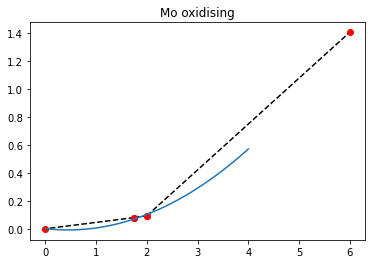

W_ox
W mp-19372 4
6.667
5.333
5.444
4.5
5.25
5.6
5.529
5.8
4.667
5.84
WARNING! Adding an end member so can perform fit, try gather more data for this element.


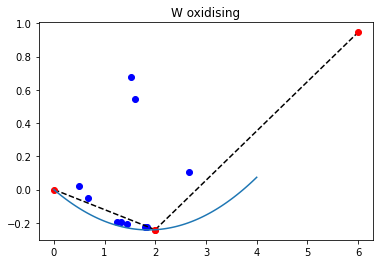

Nb_ox
Nb mp-557057 4


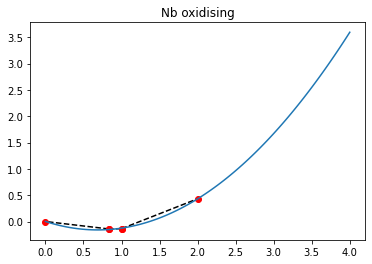

Ni_ox
Ni mp-35925 4


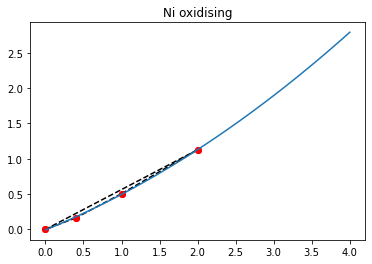

V_ox
V mp-19094 4


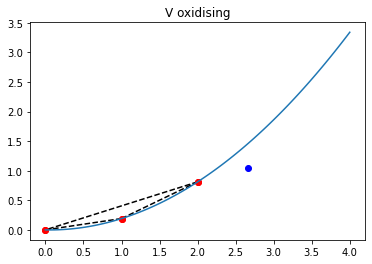

Ir_ox
Ir mp-2723 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ru_ox
Ru mp-825 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Cr_ox
Cr mp-19177 4
Fe_ox
Fe mp-1205429 4


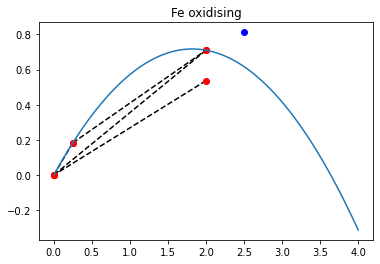

Mn_ox
Mn mp-19395 4


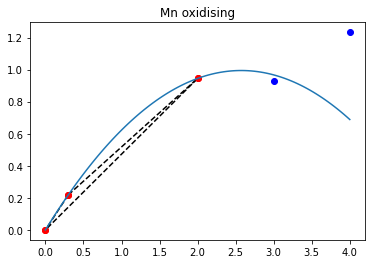

Co_ox
Co mvc-14149 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775139189  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Co  needs to be done differently.


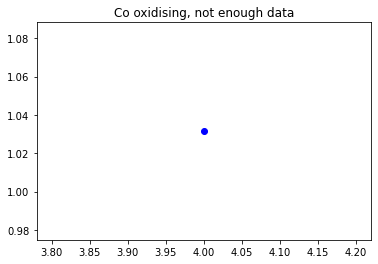

Pb_ox
Pb mp-20725 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Sb_ox
Sb mvc-5581 4


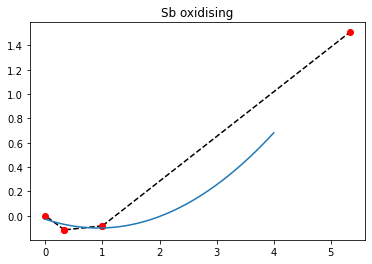

Sn_ox
Sn mp-856 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Bi_ox
Bi mp-557993 4
Ti_ox
Ti mp-390 4
Ta_ox
Ta mp-510 4


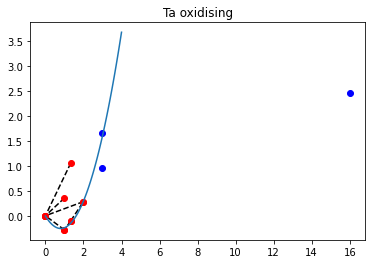

In_ox
In mp-1181008 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Pt_ox
Pt mp-1077716 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Pd_ox
Pd mp-1018886 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775206417  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Pd  needs to be done differently.


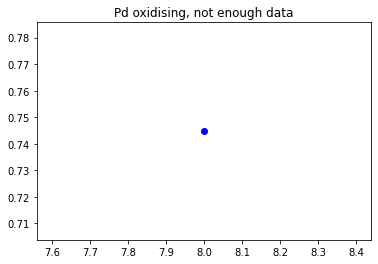

Re_ox
Re mp-12875 4


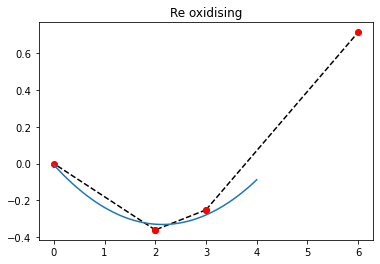

Os_ox
Os mp-996 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775206417  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Os  needs to be done differently.


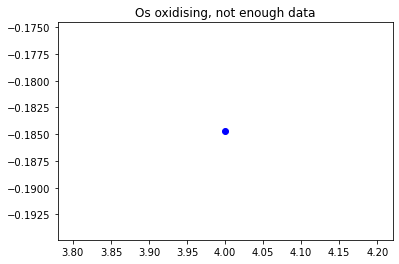

Ge_ox
Ge mp-2633 4
Tc_ox
Tc mp-1205302 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775206417  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Tc  needs to be done differently.


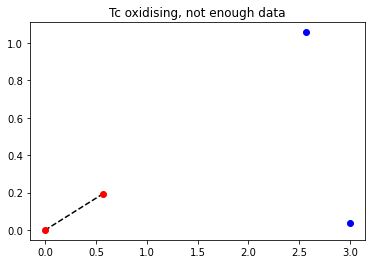

Rh_ox
Rh mp-725 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775206417  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Rh  needs to be done differently.


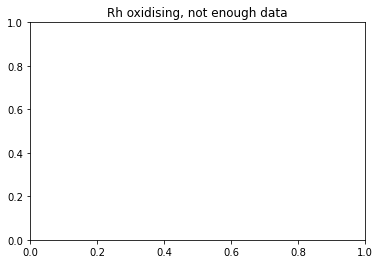

Cu_ox
Cu mp-25378 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775206417  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Cu  needs to be done differently.


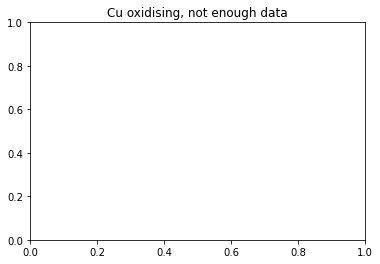

Te_ox
Te mp-2125 4
Li_ox
Li mp-1018789 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Na_ox
Na mp-1901 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ca_ox
Ca mp-634859 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775223224  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ca  needs to be done differently.


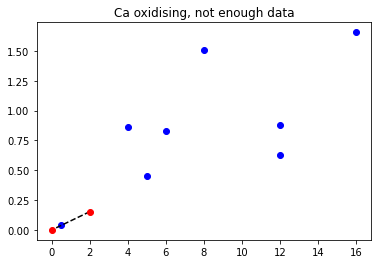

K_ox
K mp-1866 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Rb_ox
Rb mp-12105 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Cs_ox
Cs mp-1441 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775223224  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Cs  needs to be done differently.


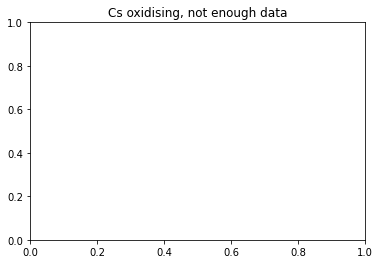

Mg_ox
Mg mp-2589 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775240031  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Mg  needs to be done differently.


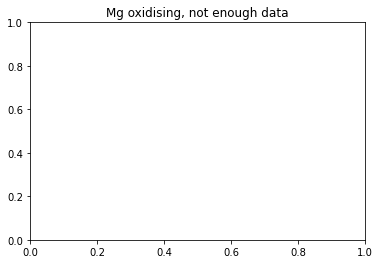

Y_ox
Y mp-1206610 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Sc_ox
Sc mp-1179114 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ba_ox
Ba mp-1105 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775256838  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ba  needs to be done differently.


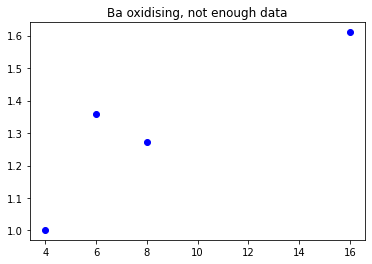

Zn_ox
Zn mp-1094003 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775256838  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Zn  needs to be done differently.


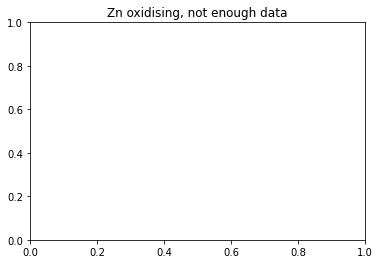

La_ox
La mp-1206559 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ce_ox
Ce mp-20194 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Pr_ox
Pr mp-1302 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Nd_ox
Nd mp-31049 4


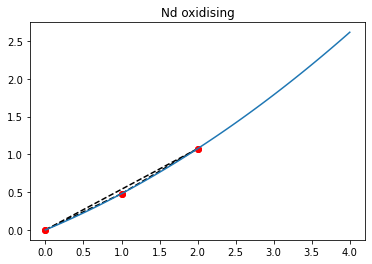

Sm_ox
Sm mp-1077235 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Eu_ox
Eu mp-1018700 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Tb_ox
Tb mp-2458 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Dy_ox
Dy mp-1206731 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Er_ox
Er mp-1206338 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Tm_ox
Tm mp-1206313 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Yb_ox
Yb mp-1178667 4
Mo_red
1.0
2.5
3.0


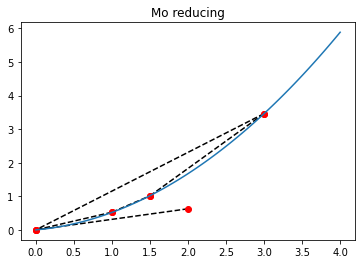

[0.31714632 0.20242573 0.0012822 ]
W_red
2.889
0.667
3.0
2.8


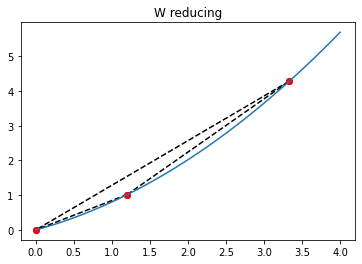

[0.20594257 0.59891615 0.        ]
Nb_red
2.0
2.5
3.0


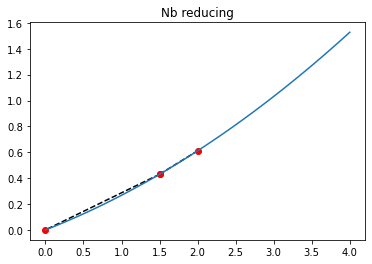

[3.80741894e-02 2.29589040e-01 3.20493781e-17]
Ni_red
2.4
0.5
2.333
2.889
2.133
3.0
2.222
2.0
1.5
1.6
2.667
2.8


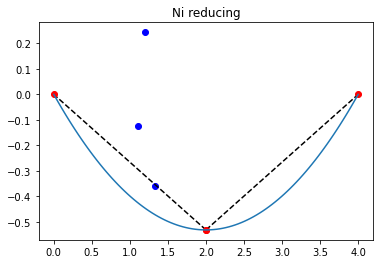

[ 1.32938532e-01 -5.31754129e-01  3.84592537e-16]
V_red
3.6
3.667
2.0
0.857
1.143
3.778
3.333
3.0
3.5
3.714
3.75
0.375
0.25
2.56
2.889
2.8
1.8
2.462


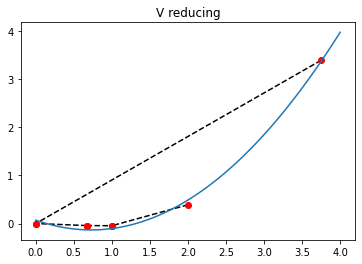

[ 0.38329437 -0.55789412  0.0702548 ]
Ir_red
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775374487  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ir  needs to be done differently.


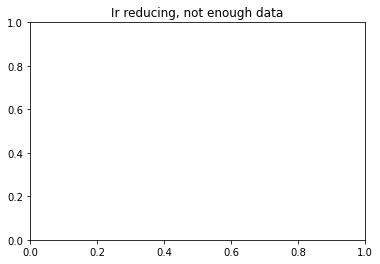

Ru_red
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775374487  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ru  needs to be done differently.


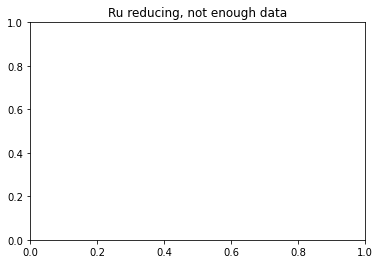

Cr_red
2.0
1.0
3.0
3.333
0.667
2.889
2.667
2.8
3.667


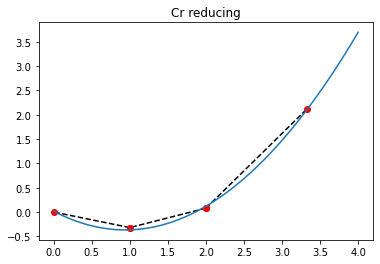

[ 0.4339388  -0.81556587  0.01623021]
Fe_red
3.0
2.0
2.667
2.143
2.286
2.25
2.2
2.571
2.133
3.2
2.923
2.977
2.783
2.222
2.5
2.732
2.118
3.048
2.154
2.8
2.56
2.889
2.053
2.057
2.174
2.19
2.187
2.308
2.182
0.667
2.167


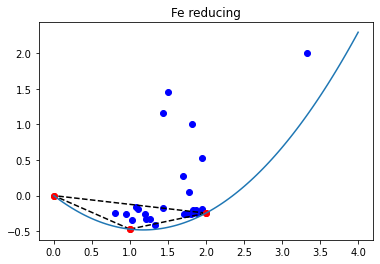

[ 3.48119488e-01 -8.19062814e-01  1.28197512e-16]
Mn_red
3.0
3.81
3.2
2.0
2.667
2.8
2.889
3.429


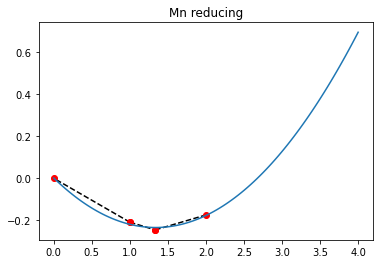

[ 0.130824   -0.35043585  0.00126574]
Co_red
3.81
2.759
2.783
2.0
2.8
2.667
3.0
3.2
3.429
2.889
3.733


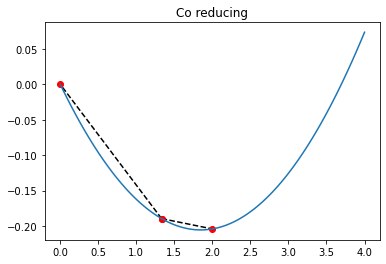

[ 0.06017167 -0.22237155  0.        ]
Pb_red
3.0
2.667
2.0
1.0
0.667
3.333


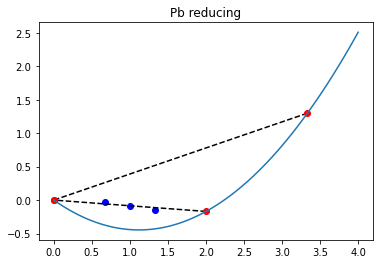

[ 3.56214331e-01 -7.97320780e-01 -5.12790050e-16]
Sb_red
3.0
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Sn_red
2.0
2.8
2.667
3.0
2.4


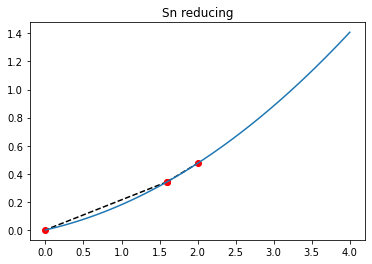

[ 5.73711772e-02  1.22514856e-01 -6.40987562e-17]
Bi_red
3.0
2.5
1.333
3.5
3.333
3.125
2.0
3.158
3.077
3.04


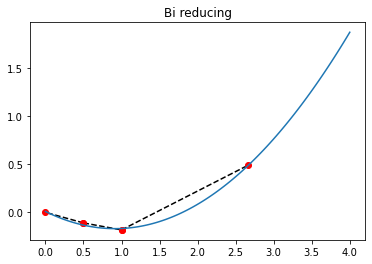

[ 0.21393463 -0.39068583  0.0093169 ]
Ti_red
2.0
0.667
3.75
1.0
3.0
2.286
2.222
3.333
2.667
1.5
2.6
3.714
3.273
3.2
2.2
2.545
1.333
2.5
3.5
0.333
3.778
3.385
3.667
1.778
2.889
3.158
2.8
3.6
3.25


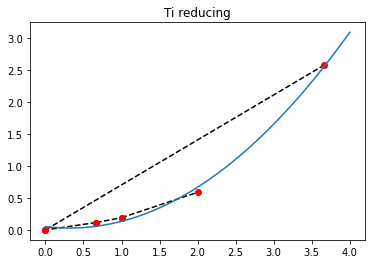

[ 0.22562952 -0.1437468   0.05252422]
Ta_red
3.0
0.364
2.0
0.5
1.909
1.8
1.0


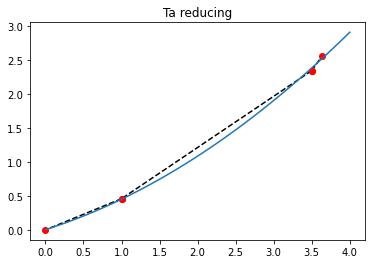

[0.09257824 0.35549017 0.00372078]
In_red
3.0
2.0


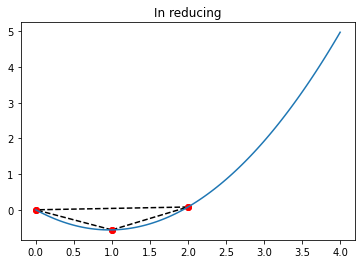

[ 6.02576324e-01 -1.16574422e+00  3.84592537e-16]
Pt_red
2.667
2.0
1.0
Pd_red
2.286
1.0
2.0


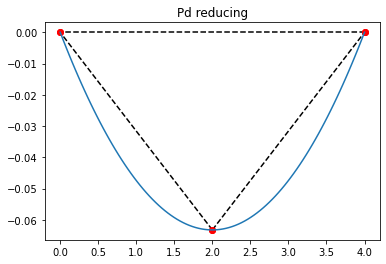

[ 1.57987242e-02 -6.31948967e-02  4.80740672e-17]
Re_red
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775508943  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Re  needs to be done differently.


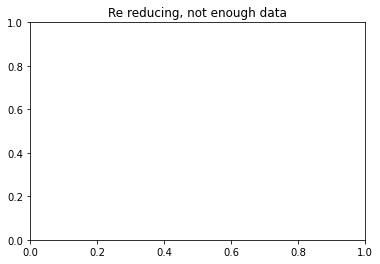

Os_red
0.667
0.0
Ge_red
0.667
3.0


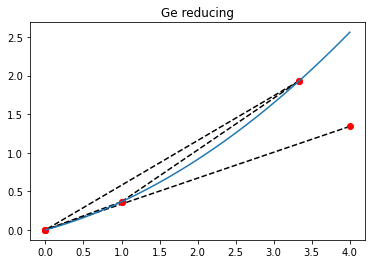

[ 9.18738311e-02  2.73138432e-01 -3.20493781e-16]
Tc_red
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 775508943  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Tc  needs to be done differently.


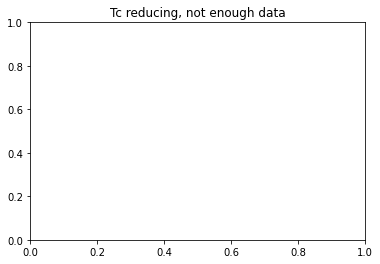

Rh_red
3.0
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Cu_red
2.0
2.667
0.25
1.75
3.0
1.5
2.889
0.031
2.8
1.333
1.0


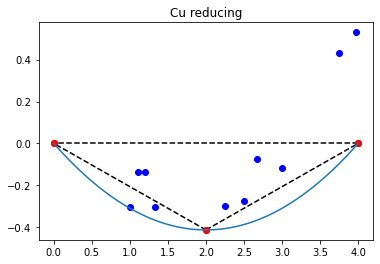

[ 1.03339303e-01 -4.13357212e-01  3.84592537e-16]
Te_red
2.0
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Li_red
1.0
2.0


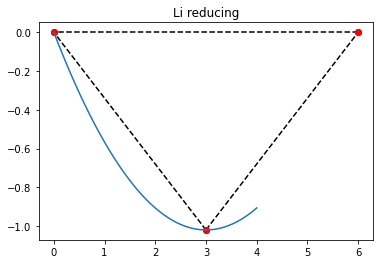

[ 1.13263837e-01 -6.79583025e-01  5.12790050e-16]
Na_red
1.0
0.333
2.0


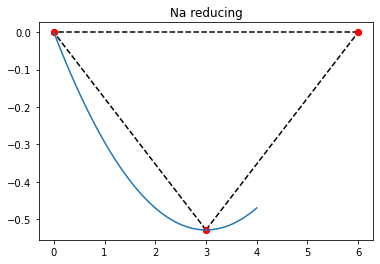

[ 5.87111780e-02 -3.52267068e-01  3.84592537e-16]
Ca_red
3.0
2.0


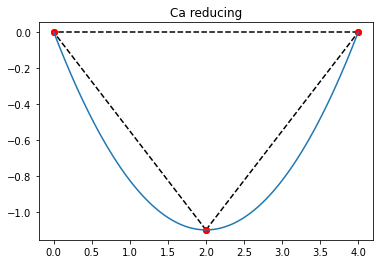

[ 2.75124134e-01 -1.10049654e+00  2.56395025e-16]
K_red
1.0
2.0


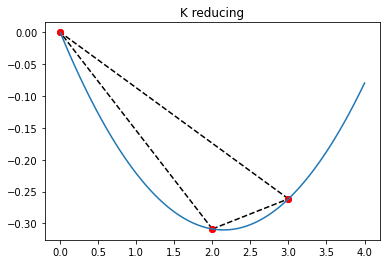

[ 6.71861110e-02 -2.88686876e-01 -1.28197512e-16]
Rb_red
0.316
1.0
3.0
2.0
0.444
0.375
0.333


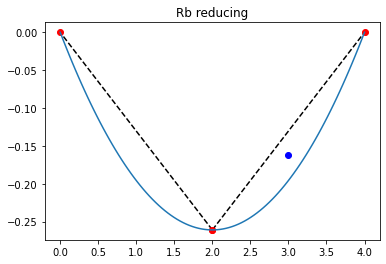

[ 6.52576243e-02 -2.61030497e-01  3.20493781e-16]
Cs_red
1.0
2.0
3.0
0.286
0.667
0.545


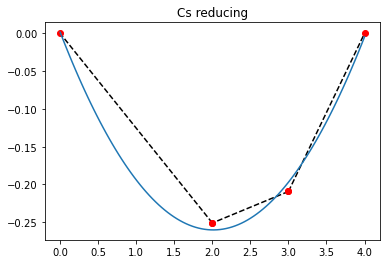

[ 0.06464862 -0.26012371  0.00152925]
Mg_red
2.0


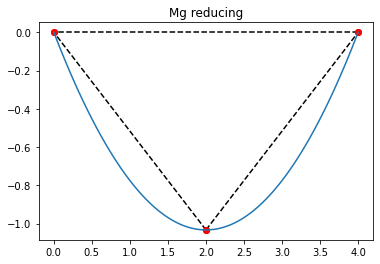

[ 2.58321635e-01 -1.03328654e+00  1.02558010e-15]
Y_red
3.0
2.0


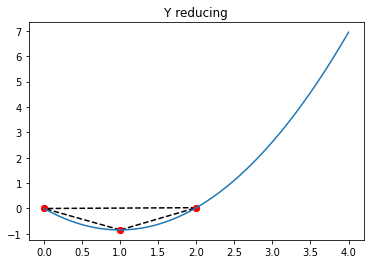

[ 8.59956453e-01 -1.70429649e+00  7.69185075e-16]
Sc_red
3.0
1.9
2.0
1.875


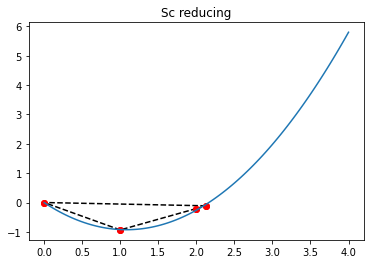

[ 0.79005198 -1.70861807 -0.00320001]
Ba_red
2.0


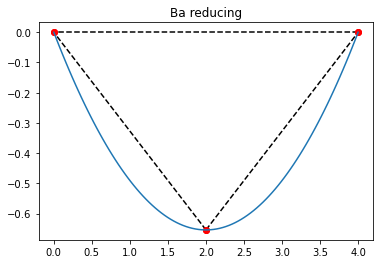

[ 1.63443994e-01 -6.53775977e-01  7.69185075e-16]
Zn_red
2.0


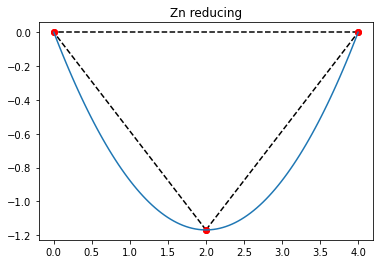

[ 2.92038556e-01 -1.16815422e+00  7.69185075e-16]
La_red
3.0
2.0


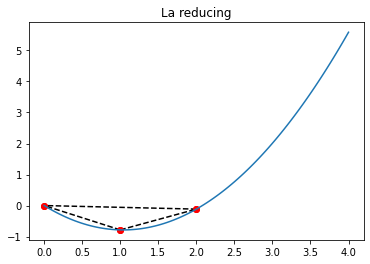

[ 7.26971650e-01 -1.51132439e+00  5.12790050e-16]
Ce_red
3.375
3.429
3.0
3.6
3.636
2.0
3.692
3.765


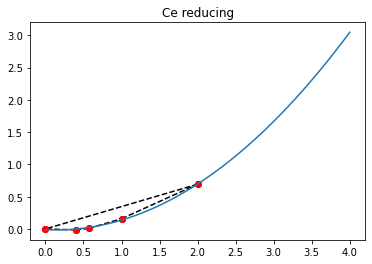

[ 0.20550755 -0.05702478 -0.01107106]
Pr_red
3.667
2.0
3.429
3.556
3.0
3.636
3.6


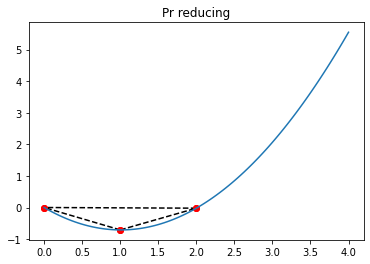

[ 6.99077013e-01 -1.40863572e+00  2.56395025e-16]
Nd_red
2.0
3.0


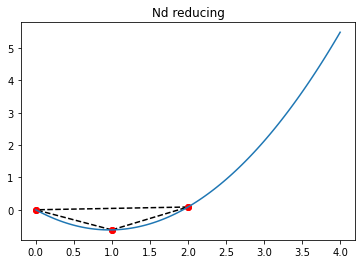

[ 6.65018797e-01 -1.28704572e+00  5.12790050e-16]
Sm_red
1.313
3.0
1.0
2.0


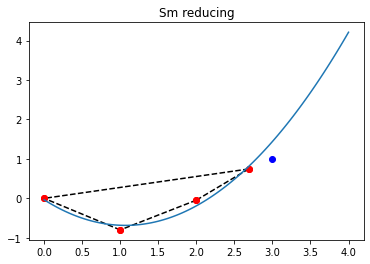

[ 0.56911939 -1.2146391  -0.03688649]
Eu_red
2.0
3.0
2.667


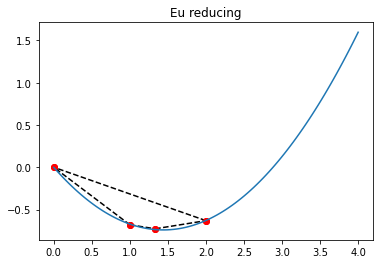

[ 0.35646528 -1.02660825 -0.00105   ]
Tb_red
3.636
3.0
3.429
3.25
3.6
3.667


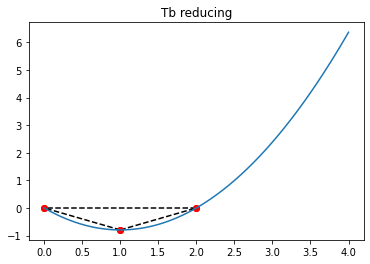

[ 7.95876994e-01 -1.59175399e+00  7.69185075e-16]
Dy_red
3.0


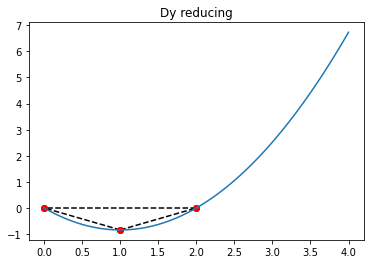

[ 8.4176005e-01 -1.6835201e+00  5.1279005e-16]
Er_red
3.0
2.0


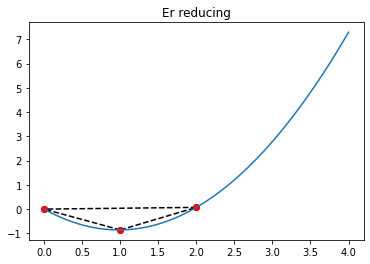

[ 8.93393051e-01 -1.75088901e+00  5.12790050e-16]
Tm_red
3.0


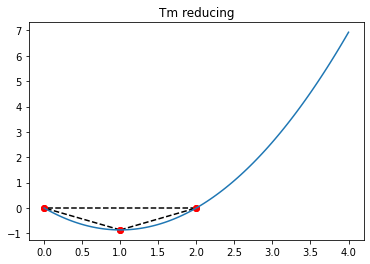

[ 8.66197205e-01 -1.73239441e+00  2.56395025e-16]
Yb_red
3.0
2.0
2.667


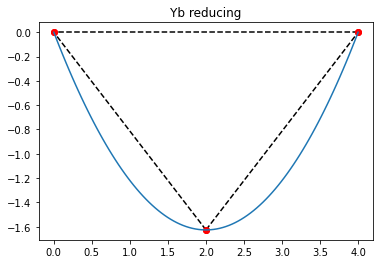

[ 4.06529969e-01 -1.62611988e+00  5.12790050e-16]


Exception ignored in: <_io.FileIO name='oqmd_quadratic_equations_ox.p' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/2482563804.py", line 96, in <cell line: 96>
Exception ignored in: <_io.FileIO name='oqmd_quadratic_equations_red.p' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_57960/2482563804.py", line 97, in <cell line: 97>


Mn
-0.15011627650137807
[0, 0.428, 0]
Fe
-0.21650603824761877
[0, 0.326025, 0]


In [44]:
ele2mp = {
    'Mo': 'mp-510536',
    'W': 'mp-19372',
    'Nb': 'mp-557057', # not rutile, 0.03 eV/atom lower
    'Ni': 'mp-35925', # layered Ni
    'V': 'mp-19094',
    'Ir': 'mp-2723',
    'Ru': 'mp-825',
    'Cr': 'mp-19177',
    'Fe': 'mp-1205429', # this is lowest FeO2, suspect rutile in MP is wrong magmoms
    'Mn': 'mp-19395', # many morphologiesi close to eachother, rutile 0.03 eV/atom
    'Co': 'mvc-14149', # layered Co mp-1272749 octahedral
    'Pb': 'mp-20725',
    'Sb': 'mvc-5581',#mp-230 omst stable, # mvc-5581 was chosen since it is 0.17 eV/atom more unstable than the most stable MP SbO2 (this is chosen because OQMD has this difference for its rutile SbO2)
    'Sn': 'mp-856',
    'Bi': 'mp-557993',#mp-557993 not rutile
    'Ti': 'mp-390',
    'Ta': 'mp-510', #mp-20994 rutile, 0.02 eV/atom higher
    'In': 'mp-1181008',
    'Pt': 'mp-1077716',
    'Pd': 'mp-1018886',
    'Re': 'mp-12875',
    'Os': 'mp-996',
    'Ge': 'mp-2633',# not rutile
    'Tc': 'mp-1205302',
    'Rh': 'mp-725',
    'Cu': 'mp-25378',
    'Te': 'mp-2125', # mp-2237 rutile, 0.25 eV/atom higher, icsd
    'Li': 'mp-1018789',
    'Na': 'mp-1901',
    'Ca': 'mp-634859',
    'K': 'mp-1866',
    'Rb': 'mp-12105',
    'Cs': 'mp-1441',
    'Mg': 'mp-2589',
    'Y': 'mp-1206610',
    'Sc': 'mp-1179114',
    'Ba': 'mp-1105',
    'Zn': 'mp-1094003',
    'La': 'mp-1206559',
    'Ce': 'mp-20194',
    'Pr': 'mp-1302',
    'Nd': 'mp-31049',
    'Sm': 'mp-1077235',
    'Eu': 'mp-1018700',
    'Tb': 'mp-2458',
    'Dy': 'mp-1206731',
    #'Ho': 'mp-1206243',
    'Er': 'mp-1206338',
    'Tm': 'mp-1206313',
    'Yb': 'mp-1178667'
}

ox_state = 4
quadratic_equations_ox = defaultdict()

for ele in ele2mp:
    print("{}_ox".format(ele))
    print(ele, ele2mp[ele], ox_state)
    ox2low, form_ene = get_ox2lowest(ele, ele2mp[ele], ox_state, oxidising=True)
    hull_ox2energy = get_lower_hull(ox2low, ox_state, form_ene, ele, oxidising=True)
    if hull_ox2energy is None:
        ref_ene, _ = get_ref_data(ele, ele2mp[ele])
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        quadratic_equations_ox[ele] = [0, -ref_ene/4,0]
        continue
    if len(hull_ox2energy.keys())==2:
        key = [x for x in hull_ox2energy.keys() if x!=0][0]
        quadratic_equations_ox[ele] = [0, hull_ox2energy[key]/key,0]
        continue

    coeffs = get_quadratic(hull_ox2energy)
    quadratic_equations_ox[ele] = coeffs
    
quadratic_equations_red = defaultdict()
for ele in ele2mp:
    print("{}_red".format(ele))
    ox2low, form_ene = get_ox2lowest(ele, ele2mp[ele], ox_state, oxidising=False)
        
    hull_ox2energy = get_lower_hull(ox2low, ox_state, form_ene, ele, oxidising=False)
    if hull_ox2energy is None:
        ref_ene, _ = get_ref_data(ele, ele2mp[ele])
        quadratic_equations_red[ele] = [0, -form_ene/4, 0]
        continue
    if len(hull_ox2energy.keys())==2:
        key = [x for x in hull_ox2energy.keys() if x!=0][0]
        quadratic_equations_red[ele] = [0, hull_ox2energy[key]/key,0]
        continue
    
    coeffs = get_quadratic(hull_ox2energy)
    print(coeffs)
    quadratic_equations_red[ele] = coeffs

    
oqmd_quadratic_equations_ox = pickle.load(open('oqmd_quadratic_equations_ox.p', 'rb'))
oqmd_quadratic_equations_red = pickle.load(open('oqmd_quadratic_equations_red.p', 'rb'))

# handle the 'needs to be done differently' or 'WARNING! Adding an end member'
# by setting those curves to the oqmd curves, if they didn't give the same issue
quadratic_equations_ox['Ru'] = oqmd_quadratic_equations_ox['Ru']
quadratic_equations_ox['Sn'] = oqmd_quadratic_equations_ox['Sn']
quadratic_equations_ox['Ir'] = oqmd_quadratic_equations_ox['Ir']
quadratic_equations_red['Sn'] = oqmd_quadratic_equations_red['Sn']
quadratic_equations_ox['Pb'] = oqmd_quadratic_equations_ox['Pb']
quadratic_equations_red['Pb'] = oqmd_quadratic_equations_red['Pb']
quadratic_equations_ox['Cr'] = oqmd_quadratic_equations_ox['Cr']

# Cr curve does not fit through Cr2O3 
#quadratic_equations_red['Cr'] = oqmd_quadratic_equations_red['Cr']

# handle any wrongly shaped curves
for ele in set(list(quadratic_equations_ox.keys())+list(quadratic_equations_red.keys())):
    if quadratic_equations_ox[ele][0]<0 and ele in oqmd_quadratic_equations_ox.keys():
        print(ele)
        print(quadratic_equations_ox[ele][0])
        print(oqmd_quadratic_equations_ox[ele])
        quadratic_equations_ox[ele] = oqmd_quadratic_equations_ox[ele]
    if quadratic_equations_red[ele][0]<0 and ele in oqmd_quadratic_equations_red.keys():
        print(ele)
        print(quadratic_equations_red[ele][0])
        print(oqmd_quadratic_equations_red[ele])
        quadratic_equations_red[ele] = oqmd_quadratic_equations_red[ele]


In [ ]:
mp_quadratic_equations_red

In [ ]:
pickle.dump(mp_quadratic_equations_ox, open("mp_quadratic_equations_ox6.p", "wb"))
pickle.dump(mp_quadratic_equations_red, open("mp_quadratic_equations_red6.p", "wb"))


In [ ]:
mp_quadratic_equations_ox